# Project: Wrangling WeRateDogs Twitter Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Data Gathering</a></li>
<li><a href="#assess">Assesing Data</a></li>
<li><a href="#clean">Cleaning</a>
    <ul>
        <li><a href="#quality">Quality</a></li>
        <li><a href="#tidy">Tidiness</a></li>
    </ul>
 </li>
<li><a href="#analyze">Analyzing and Visualizing Data</a></li>
</ul>


<a id='intro'></a>

## Introduction

WeRateDogs is a Twitter account that rates user submitted photos, usually with humorous content. It has a unique rating system that comprises of a numerator and denominator. The numerator is usually greater than that the denominator. The main object of this project will be gather, wrangle and retrieve some insights of the WeRateDogs account that will be retrieved from different sources. 

In [562]:
import pandas as pd
import requests
import os
import glob
import json
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


<a id='gather'></a>
## Data Gathering

Download the WeRateDogs *[Twitter archive](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv)* by clicking on the download link.

Use the `pd.read_csv` method to load the data into a Pandas Dataframe

In [3]:
archives_df = pd.read_csv('twitter-archive-enhanced.csv')

Use the Requests library to download the tweet image prediction file (image_predictions.tsv)

In [4]:
#Make a new folder to hold downloaded image-predictions tsv file

folder = 'Predictions'
if not os.path.exists(folder):
    os.makedirs(folder)

In [6]:
#Download file using the requests library 

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [7]:
#write the contents of the response into a file in the Predictions folder

with open(os.path.join(folder, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)


Confirm the contents of the `Predictions` folder:

In [8]:
#lists all the folders/lists of specified directory

os.listdir('Predictions')

['image-predictions.tsv']

Now that we have confirmed that the image-predictions file has been successfully created, we can proceed with reading its contents and loading them into a dataframe

In [1178]:
#Read Data from the Image Predictions file into a dataframe

predictions_df = pd.read_csv('Predictions\image-predictions.tsv', sep='\t')

 

We are going to download additional data to supplement our datasets from this **[link](https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt)**. I opted for a direct download because my request for elavated access to twitter's API was rejected.   

Once you've downloaded the tweet-json text file move it into your working directory. 

In [1179]:
#Create an empty list that will be used to hold the dictionary objects read from the Json txt file

json_list = []

Read JSON Data from the `tweet-json.txt` Text File

In [1180]:
'''
 Use glob module to loop through and find text files in your working directory
 Employ a for loop together with .readline() to read lines in the text file
 Parse the String returned by the readline method into a Python dictionary with the json.loads method
 Create a python dictionary that will be loaded into the empty Json_list list
 Confirm if dictionary is present in list, if not append to list, else skip. This will ensure we dont append duplicates
'''

for tweet_file in glob.glob('*.txt'):
    with open(tweet_file, encoding='utf-8') as file:
        for line in file:
            txt_obj = file.readline()
            tweet_obj = json.loads(txt_obj)
            tweet_dict = {'tweet_id' : tweet_obj['id'], 'created_at' : tweet_obj['created_at'], 
                          'retweet_count' : tweet_obj['retweet_count'],'favorite_count' : tweet_obj['favorite_count'],
                          'followers_count' : tweet_obj['user']['followers_count']}
            if tweet_dict not in json_list:
                json_list.append(tweet_dict)

Let's check whether the objects loaded into our json_list were of the Python *`dict`* datatype  

In [1181]:
#Type of the zero-indexed object in the json_list list

assert(type(json_list[0]) == dict)

Optionally, we can use the *`isinstance`* function that checks and returns *`True`* if the specified object is a subclass or an instance of the indicated type

In [1182]:
#Type of last-indexed object in the json_list

isinstance(json_list[-1], dict)

True

We'll use the *`from_dict`* method to construct a dataframe from our dictionaries in the json_list list. 

In [1183]:

additional_tweets_df = pd.DataFrame.from_dict(json_list)

Check if the tweet_ids in the newly created additional_tweets_df are in the archives dataframe.   

In [1184]:
#counts the number of items in the additional_tweets_df, tweet_id column and checks if item is present in archive

items = 0
for item in set(list(additional_tweets_df.tweet_id)):
    if item in list(archives_df.tweet_id):
        items += 1

In [1185]:
'''
    compare the count against the length of the additional tweets dataframe
    if count is equal to length of additional df, then all tweets in new df were in the archived df 
'''

items == len(list(additional_tweets_df.tweet_id))

True

<a id='assess'></a>
## Assessing Data

### Quality issues
1. archive_df: duplicate tweets inform of retweets

2. archive_df: tweet_id is an integer instead of a string object

3. archive_df:  *timestamp* is a string object 

4. archive_df: *in_reply_to_user_id*, *in_reply_to_status_id*, *retweeted_status_timestamp*, *retweeted_status_id* and *retweeted_status_user_id* columns have null values 

5. archive_df: The source of the tweet is embedded in html tags in the *source* column 

6. archive_df: missing *names* represented as None 

7. archive_df: *names* extracted incorrectly in some cases i.e 'a', 'the', 'an'  

8. archive_df: *rating_denominator* is greater than or less than 10 in some cases 



### Tidiness Issues

1. The *doggo*, *floofer*, *pupper* and *puppo* identifiers should unpivoted into a single column

2. The *created_at* column in the additional_tweets_df should be dropped, it is already present in the archives_df as *timestamp*. 

let's make a visual inspection of our first dataframe

In [1186]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_row', None)

##### archives_df Table

In [1187]:
archives_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
637,793286476301799424,NaN,NaN,2016-11-01 03:00:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Moreton. He's the Good Boy Who Lived. 13/10 magical as h*ck https://t.co/rLHGx3VAF3,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/793286476301799424/photo/1,https://twitter.com/dog_rates/status/793286476301799424/photo/1",13,10,Moreton,None,None,None,None
1332,705475953783398401,NaN,NaN,2016-03-03 19:32:29 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Zara. She found a sandal and couldn't be happier. 12/10 great work https://t.co/zQUuVu812n,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/705475953783398401/photo/1,https://twitter.com/dog_rates/status/705475953783398401/photo/1",12,10,Zara,None,None,None,None
345,831939777352105988,NaN,NaN,2017-02-15 18:54:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Emanuel. He's a h*ckin rare doggo. Dwells in a semi-urban environment. Round features make him extra collectible. 12/10 would so pet https://t.co/k9bzgyVdUT,NaN,NaN,NaN,https://twitter.com/dog_rates/status/831939777352105988/photo/1,12,10,Emanuel,doggo,None,None,None
2224,668291999406125056,NaN,NaN,2015-11-22 04:56:43 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I can't do better than he did. 10/10 https://t.co/fM0KXns7Or,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668291999406125056/photo/1,10,10,None,None,None,None,None
648,793120401413079041,NaN,NaN,2016-10-31 16:00:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Robin. She's desperately trying to do me a frighten, but her tongue drastically decreases her spook value. Still 11/10 great effort https://t.co/sxMrsOZ8zb",NaN,NaN,NaN,https://twitter.com/dog_rates/status/793120401413079041/photo/1,11,10,Robin,None,None,None,None


In [1188]:
archives_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [1280]:
archives_df.shape

(2356, 17)

In [1189]:
archives_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


Check for duplicates in the *`tweet_id`* column

In [1190]:
archives_df['tweet_id'].duplicated().sum()

0

There are **no** duplicates in the archives_df dataframe. 

In [1191]:
archives_df.duplicated().sum()

0

Let us examine the *name* column

In [1192]:
archives_df.name.value_counts()

None              745
a                  55
Charlie            12
Cooper             11
Lucy               11
Oliver             11
Tucker             10
Penny              10
Lola               10
Winston             9
Bo                  9
Sadie               8
the                 8
Daisy               7
Buddy               7
Toby                7
an                  7
Bailey              7
Leo                 6
Oscar               6
Stanley             6
Rusty               6
Bella               6
Dave                6
Jack                6
Koda                6
Scout               6
Jax                 6
Milo                6
Louis               5
Phil                5
Sammy               5
Gus                 5
Chester             5
Alfie               5
Sunny               5
Bentley             5
very                5
Oakley              5
Finn                5
George              5
Larry               5
Clarence            4
Loki                4
Walter              4
Reggie    

In [1193]:
archives_df[archives_df.name == 'a'].sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2128,670303360680108032,NaN,NaN,2015-11-27 18:09:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670303360680108032/photo/1,9,10,a,None,None,None,None
2211,668614819948453888,NaN,NaN,2015-11-23 02:19:29 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a horned dog. Much grace. Can jump over moons (dam!). Paws not soft. Bad at barking. 7/10 can still pet tho https://t.co/2Su7gmsnZm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668614819948453888/photo/1,7,10,a,None,None,None,None
2235,668171859951755264,NaN,NaN,2015-11-21 20:59:20 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Trans Siberian Kellogg named Alfonso. Huge ass eyeballs. Actually Dobby from Harry Potter. 7/10 https://t.co/XpseHBlAAb,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668171859951755264/photo/1,7,10,a,None,None,None,None


In [1194]:
archives_df[archives_df.name == 'an'].sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2204,668636665813057536,NaN,NaN,2015-11-23 03:46:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668636665813057536/photo/1,10,10,an,None,None,None,None
1025,746369468511756288,NaN,NaN,2016-06-24 15:48:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746369468511756288/photo/1,9,10,an,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2,10,an,None,None,None,None


Let's count the number of null value in the *in_reply_to_status_id* column

In [1195]:
sum(archives_df.in_reply_to_status_id.isnull())

2278

Number of null values in the in_reply_to_user_id

In [1196]:
sum(archives_df.in_reply_to_user_id.isnull())

2278

Number of null values in the *retweeted_status_id*

In [1197]:
sum(archives_df.retweeted_status_id.isnull())

2175

Number of null values in the *retweeted_status_user_id*

In [1198]:
sum(archives_df.retweeted_status_user_id.isnull())

2175

No. of unique values in the *rating_denominator* column with their respective counts

In [1199]:
archives_df.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

There are several entries with a rating of more than 10

##### Predictions Table

In [1200]:
#retrieve a sanple of 10 rows from dataframe

predictions_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
119,668171859951755264,https://pbs.twimg.com/media/CUXSwy8W4AA6uet.jpg,1,Chihuahua,0.664834,True,cowboy_boot,0.060343,False,giant_panda,0.059838,False
30,666418789513326592,https://pbs.twimg.com/media/CT-YWb7U8AA7QnN.jpg,1,toy_terrier,0.149680,True,papillon,0.148258,True,Chihuahua,0.142860,True
165,668979806671884288,https://pbs.twimg.com/media/CUixld6WoAArDrJ.jpg,1,golden_retriever,0.608537,True,Irish_setter,0.097078,True,redbone,0.076022,True
798,691096613310316544,https://pbs.twimg.com/media/CZdEq-AUMAAWayR.jpg,1,borzoi,0.441269,True,llama,0.278270,False,Arabian_camel,0.063503,False
307,671533943490011136,https://pbs.twimg.com/media/CVHEju0XAAEUZRY.jpg,1,hen,0.556524,False,cock,0.442033,False,black_swan,0.001181,False
1314,754856583969079297,https://pbs.twimg.com/media/CnnKCKNWgAAcOB8.jpg,2,golden_retriever,0.872385,True,Labrador_retriever,0.099963,True,cocker_spaniel,0.006051,True
1431,773247561583001600,https://pbs.twimg.com/media/Crsgi9dWEAApQd8.jpg,1,seat_belt,0.713588,False,miniature_pinscher,0.083369,True,Brabancon_griffon,0.075696,True
1517,787322443945877504,https://pbs.twimg.com/media/Cu0hlfwWYAEdnXO.jpg,1,seat_belt,0.747739,False,golden_retriever,0.105703,True,dingo,0.017257,False
980,707315916783140866,https://pbs.twimg.com/media/CdDkEkHWwAAAeUJ.jpg,2,Bernese_mountain_dog,0.979235,True,Shetland_sheepdog,0.011037,True,Appenzeller,0.003971,True
1433,773547596996571136,https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg,1,Norwegian_elkhound,0.372202,True,Chesapeake_Bay_retriever,0.137187,True,malamute,0.071436,True


In [1201]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [1202]:
#retrieve descriptive statistics

predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [1203]:
#Check for duplicates

predictions_df.tweet_id.duplicated().sum()

0

There are **no** duplicates in the predictions dataFrame

##### additional_tweets_df

In [1204]:
additional_tweets_df.sample(10)

,tweet_id,created_at,retweet_count,favorite_count,followers_count
139,839549326359670784,Wed Mar 08 18:52:12 +0000 2017,8805,29957,3200891
1090,668989615043424256,Tue Nov 24 03:08:48 +0000 2015,356,726,3201012
923,675781562965868544,Sat Dec 12 20:57:34 +0000 2015,537,1750,3201002
921,675845657354215424,Sun Dec 13 01:12:15 +0000 2015,1000,2477,3201002
445,759446261539934208,Sat Jul 30 17:51:13 +0000 2016,561,1846,3200908
488,749981277374128128,Mon Jul 04 15:00:45 +0000 2016,2772,5569,3200943
462,754856583969079297,Mon Jul 18 01:53:28 +0000 2016,2870,7616,3200943
1042,670797304698376195,Sun Nov 29 02:51:54 +0000 2015,262,780,3201008
910,676533798876651520,Mon Dec 14 22:46:41 +0000 2015,621,2025,3201002
918,675891555769696257,Sun Dec 13 04:14:39 +0000 2015,976,2297,3201002


In [1205]:
additional_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         1177 non-null   int64 
 1   created_at       1177 non-null   object
 2   retweet_count    1177 non-null   int64 
 3   favorite_count   1177 non-null   int64 
 4   followers_count  1177 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 46.1+ KB


In [1206]:
#retrieve descriptive stats

additional_tweets_df.describe()

,tweet_id,retweet_count,favorite_count,followers_count
count,1.177000e+03,1177.000000,1177.000000,1.177000e+03
mean,7.426493e+17,3107.338997,7901.181818,3.200942e+06
std,6.851760e+16,5458.476288,11536.383916,4.432643e+01
min,6.660209e+17,2.000000,0.000000,3.200802e+06
25%,6.783968e+17,613.000000,1339.000000,3.200898e+06
50%,7.193678e+17,1460.000000,3553.000000,3.200945e+06
75%,7.992971e+17,3628.000000,9872.000000,3.200953e+06
max,8.921774e+17,79515.000000,131075.000000,3.201018e+06


In [1207]:
#check for duplicates

additional_tweets_df.duplicated().sum()

0

The range for retweet_count, favourite_count and followers_count columns from **min** and **max** rows are whole numbers   


Let's check for duplicate columns in our 3 dataframes

In [1208]:
column_series = pd.Series(list(archives_df) + list(additional_tweets_df) + list(predictions_df))
column_series[column_series.duplicated()]


17    tweet_id
22    tweet_id
dtype: object

We will use the duplicated column to join our dataframes

<a id='clean'></a>
## Cleaning Data


# Make copies of original pieces of data

In [1209]:
archives_clean = archives_df.copy()
predictions_clean = predictions_df.copy()
additional_clean = additional_tweets_df.copy()

<a id='quality'></a>
### Quality issues


### Issue #1: archives_df - duplicate tweets inform of retweets

#### Define:
* Delete retweets that can be identified with rows that have a value in *retweeted_status_id* column

#### Code

In [1210]:
#filter rows with values in retweeted_status_id column

archives_clean[archives_clean['retweeted_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397445533696/photo/1,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1",14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" re

In [1211]:
#create a new df that exxludes the filtered rows

archives_clean = archives_clean[archives_clean['retweeted_status_id'].isnull()]

## Test

In [1212]:
#count number of rows with retweeted_status_id is zero

assert(archives_clean['retweeted_status_id'].notnull().sum() == 0)

### Issue #2: tweet_id is an integer instead of a string object

#### Define
* Change the datatype of tweet_id from an integer to a String

#### Code

In [1213]:
#use astype method to convert to desired datatype

archives_clean['tweet_id'] = archives_clean['tweet_id'].astype('str')

#### Test: 

In [1214]:
#confirm that tweet_id is of class object

assert(archives_clean.tweet_id.dtype == 'O')

### Issue #3: archives_df - timestamp is a string object 

In [1215]:
#Retrieve a sample of the timestamp column

archives_clean.timestamp.sample(1)

2031    2015-12-01 19:10:13 +0000
Name: timestamp, dtype: object

#### Define

* Convert string to a datetime object

#### Code 

In [1216]:
# use to_datetime function to convert str to a pandas datetime object 

archives_clean['timestamp'] = pd.to_datetime(archives_clean.timestamp)

#### Test

In [1217]:
#confirm that the resulting column is of datetime - UTC timezone column

assert(archives_clean['timestamp'].dtype == 'datetime64[ns, UTC]')

### Issue #4: archives_df - in_reply_to_user_id, in_reply_to_status_id, retweeted_status_timestamp, retweeted_status_id and retweeted_status_user_id columns have null values 

#### Define
* Delete indicated columns from dataframe

#### Code

In [1218]:
archives_clean.sample(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1701,680940246314430465,NaN,NaN,2015-12-27 02:36:20+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Alice. She's an idiot. 4/10 https://t.co/VQXdwJfkyS,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680940246314430465/photo/1,4,10,Alice,None,None,None,None


In [1219]:
#List of columns to be dropped

to_be_deleted = ['in_reply_to_user_id', 'in_reply_to_status_id', 
                  'retweeted_status_timestamp', 'retweeted_status_id', 
                  'retweeted_status_user_id']

In [1220]:
archives_clean = archives_clean.drop(columns=to_be_deleted)

#### Test

In [1221]:
#checks if any of the columns in the new df are in to_be_deleted list
#Returns ''Specified columns were all deleted'' if specified columns were deleted

def check_columns():
    for column in archives_clean.columns:
        if column in to_be_deleted:
            return ('{} was not deleted'.format(column))
        return('Specified columns were all deleted')
print(check_columns())

Specified columns were all deleted


### Issue #5 archives_df:  The source of the tweet  is embedded in html tags in the source column 

#### Define
* Retrieve the source of the tweet from the string object

#### Code

In [1222]:
'''
Split the string using '>' and use indexing to one-indexed obejct
split the resulting object on a whitespace and pick the last item
strip whitespace from the string
finally srip the closing anchor tag from the str

'''

archives_clean['source'] = archives_clean['source'].apply(lambda x: x.split('>')[1].split()[-1].strip().strip('</a'))

#### Test 

In [1223]:
#Count the number of unique items

archives_clean['source'].value_counts()

iPhone       2042
Scene          91
Client         31
TweetDeck      11
Name: source, dtype: int64

In [1224]:
#Check for unique items in source column

archives_clean['source'].unique()

array(['iPhone', 'Client', 'Scene', 'TweetDeck'], dtype=object)

We've successfully stripped away the HTML tag and remained with clean sources of tweets *'iPhone', 'Client', 'Scene', 'TweetDeck'* 

### Issue #6 archives_df:  missing name represented as None

#### Define
* Replace None string entries in the name column with a meaningful descriptor (No Name)

#### Code

In [1225]:
# replace every instance of the word None with 'No Name'

archives_clean['name'] = archives_clean['name'].replace('None', 'No_Name')

#### Test 

In [1226]:
#confirm that None is not the name column

assert None not in archives_clean['name'].unique()

### Issue #7 archives_df: some names were extracted incorrectly in some cases i.e 'a', 'the', 'an'

### Define
* Replace incorrectly extracted names with 'incorrect_name'

In [1227]:
archives_clean.name = archives_clean.name.replace([ 'a', 'the', 'an'], 'incorrect_name')

#### Test

In [1228]:
#Loop through elements and confirm that they are not in name column:

for name in [ 'a', 'the', 'an']:
    assert name not in archives_clean.name.unique()

### Issue #8 archives_df - *rating_denominator* is greater than or less than 10 in some cases 

#### Define
* Replace all values that are not equal to 10 in the rating_denominator with 10

#### Code

In [1229]:
#use loc to access and filter rating_denominator values greater than 10

archives_clean.loc[archives_clean.rating_denominator != 10, 'rating_denominator'] = 10

#### Test

In [1230]:
#Test for values greater than 10 in rating _denominator

for num in archives_clean.rating_denominator:
    assert num == 10

In [1231]:
archives_clean.rating_denominator.unique()

array([10], dtype=int64)

<a id='tidy'></a>
### Tidiness 

In [1232]:
archives_clean.sample(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1135,728409960103686147,2016-05-06 02:24:02+00:00,iPhone,This is Wallace. He's a skater pup. He said see ya later pup. Can easily do a kick flip. Gnarly af. 10/10 v petable https://t.co/5i8fORVKgr,https://twitter.com/dog_rates/status/728409960103686147/photo/1,10,10,Wallace,None,None,None,None
523,809448704142938112,2016-12-15 17:23:04+00:00,iPhone,"I call this one ""A Blep by the Sea"" 12/10 https://t.co/EMdnCugNbo",https://twitter.com/dog_rates/status/809448704142938112/photo/1,12,10,No_Name,None,None,None,None


### Issue #1 The doggo, floofer, pupper and puppo identifiers should unpivoted into a single column

#### Define
* Reshape the doggo, floofer, pupper and puppo into a single column

#### Code


In [1233]:

archives_clean_1 = pd.melt(archives_clean, value_name='category', var_name='dog_category', id_vars=['tweet_id', 'timestamp',
                                                            'source', 'text', 'expanded_urls', 
                                                            'rating_denominator','rating_numerator', 
                                                            'name'])

In [1234]:
##Dataframe/filter where the value_name category is NOT None

archives_clean_1 = archives_clean_1[archives_clean_1.category != 'None']

In [1235]:
#Drop the var_name dog_category column as it wont be need

archives_clean_1.drop(columns='dog_category', inplace=True)

In [1236]:
#Check for duplicates

archives_clean_1.duplicated().sum()

0

In [1237]:
#confirm the unique items in the Category column

archives_clean_1.category.unique()

array(['doggo', 'floofer', 'pupper', 'puppo'], dtype=object)

Create a second dataframe that excludes the `tweet_ids` in the dataframe above.  

In [1238]:
archives_clean_2 = pd.melt(archives_clean, value_name='category', var_name='dog_category', id_vars=['tweet_id', 'timestamp',
                                                            'source', 'text', 'expanded_urls', 
                                                            'rating_denominator','rating_numerator', 
                                                            'name'])

In [1239]:
#Filter rows that have none value in the Category column 

archives_clean_2 = archives_clean_2[archives_clean_2.category == 'None']

Drop the `dog_category` column from the dataframe so that we can be able to drop duplicate rows

In [1240]:
archives_clean_2.drop(columns='dog_category', inplace=True)

In [1241]:
#Drop duplicated rows

archives_clean_2.drop_duplicates(inplace=True)

In [1242]:
#Drop rows that are present in archives_clean_1 

archives_clean_2 = archives_clean_2[~archives_clean_2.tweet_id.isin(list(archives_clean_1.tweet_id))]

Concat the two dataframes

In [1243]:
#Append archives_clean_2 to archives_clean_1

archives_melted = pd.concat([archives_clean_1, archives_clean_2])

#### Tidiness Issue #2. The created_at column in the additional_tweets_df should be dropped, it is already present in the archives_df as timestamp.

#### Code

In [1244]:
#use drop method

additional_tweets_df.drop(columns='created_at', inplace=True)

##### Test

In [1245]:
assert 'created_at' not in additional_tweets_df.columns




Combine all the dataframes into a single table

In [1246]:
#Concat all the the 3 dataframes along the y-axis

twitter_archive_master = pd.concat([archives_melted, predictions_df, additional_tweets_df], axis=1 )

In [1247]:
#twitter_archive_master.reset_index(inplace=True)

## Storing Data

Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [1248]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

<a id='analyze'></a>
## Analyzing and Visualizing Data

##### Questions to investigate

1. Which day of the week that most of the tweets were sent out?
2. How do tweets that were sent out in the morning compare to tweets sent out in the afternoon?
3. what is the most common dog name in the dataset?

In [1279]:
#Summary stats of the combined dataframe

twitter_archive_master.describe()

,rating_denominator,rating_numerator,tweet_id,img_num,p1_conf,p2_conf,p3_conf,tweet_id,retweet_count,favorite_count,followers_count
count,2187.0,2187.000000,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03,1.177000e+03,1177.000000,1177.000000,1.177000e+03
mean,10.0,13.204390,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02,7.426493e+17,3107.338997,7901.181818,3.200942e+06
std,0.0,47.594984,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02,6.851760e+16,5458.476288,11536.383916,4.432643e+01
min,10.0,0.000000,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10,6.660209e+17,2.000000,0.000000,3.200802e+06
25%,10.0,10.000000,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02,6.783968e+17,613.000000,1339.000000,3.200898e+06
50%,10.0,11.000000,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02,7.193678e+17,1460.000000,3553.000000,3.200945e+06
75%,10.0,12.000000,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02,7.992971e+17,3628.000000,9872.000000,3.200953e+06
max,10.0,1776.000000,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01,8.921774e+17,79515.000000,131075.000000,3.201018e+06


##### Research Question 1.  Which day of the week that most of the tweets were sent out?

We'll retrieve the day of the week from the timestamp column and use it to create a new column

In [1251]:
# convert timestamp column to day of week name using the day_name method 

twitter_archive_master['dayofweek'] = twitter_archive_master['timestamp'].dt.day_name()

In [1252]:
#change the datatype of column to categorical

twitter_archive_master['dayofweek'].astype('category')


9       Wednesday
40         Sunday
89         Friday
97         Sunday
98       Saturday
108       Tuesday
149        Monday
165      Saturday
172        Monday
206       Tuesday
213        Friday
255     Wednesday
268      Thursday
272       Tuesday
279      Saturday
286      Thursday
288      Thursday
289     Wednesday
295       Tuesday
304     Wednesday
305     Wednesday
313        Sunday
324      Thursday
325     Wednesday
328       Tuesday
330        Monday
355     Wednesday
357       Tuesday
360        Monday
367        Friday
373     Wednesday
374     Wednesday
382      Saturday
403     Wednesday
407        Monday
413        Sunday
415        Sunday
442        Monday
467        Friday
474       Tuesday
475       Tuesday
481      Saturday
482        Friday
495     Wednesday
502        Monday
561      Thursday
567       Tuesday
585        Monday
588      Saturday
591        Friday
593      Thursday
603        Sunday
629       Tuesday
631        Monday
653      Saturday
674       

In [1253]:
#list of unique weekday names

days = twitter_archive_master['dayofweek'].unique()

In [1254]:
#retrieve weekday counts

counts = twitter_archive_master['dayofweek'].value_counts()

In [1255]:
counts

Monday       359
Tuesday      328
Wednesday    322
Friday       307
Thursday     307
Saturday     287
Sunday       277
Name: dayofweek, dtype: int64

In [1256]:
#display the highest count:
    
counts.max()

359

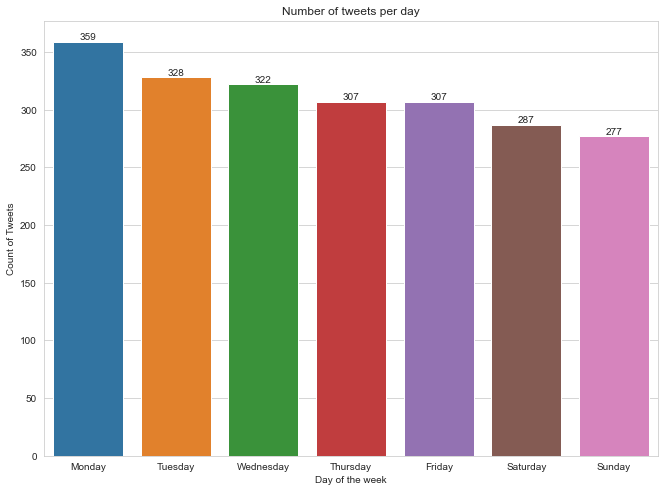

In [1257]:
plt.figure(figsize = (11,8))

ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

daybar = sns.countplot(x=twitter_archive_master['dayofweek'], order=ordered_days)

for bar in daybar.containers:
    daybar.bar_label(bar)
   
daybar.set(title='Number of tweets per day',
          ylabel='Count of Tweets',
          xlabel='Day of the week');

###### Insight 1:
The day with the most number of tweets is Monday

##### Research Question 2. How do tweets that were sent out in the morning compare to tweets sent out in the afternoon?

In [1258]:
#group timestamp column into 'Morning' and 'Afternoon'

time_diff = twitter_archive_master['favorite_count' ].groupby(twitter_archive_master['timestamp'].dt.hour <=12).sum().rename(
    {True: 'Morning', False: 'Afternoon'})

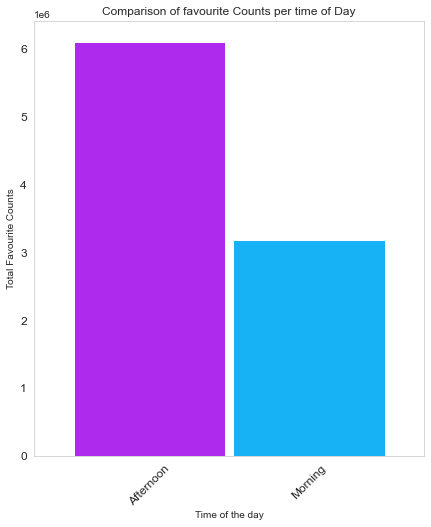

In [1259]:
#Plot bar chart to visualize the time_diff findings

plt.figure(figsize = (7,8))
time_diff_bar= time_diff.plot.bar(xlabel='Time of the day', 
                                  color=['#AE2AEC', '#17B2F6'],
                                  ylabel='Total Favourite Counts', 
                                  title = 'Comparison of favourite Counts per time of Day',
                                  rot=45, 
                                  fontsize=12,
                                  width=0.95,
                                  grid=False
                                  
                             )

In [1260]:
time_difftime

timestamp
Afternoon    6110575.0
Morning      3189116.0
Name: favorite_count, dtype: float64

In [1284]:
(time_diff.Afternoon - time_diff.Morning)/((time_diff.Afternoon + time_diff.Morning))*100

31.414581409210264

###### Insight 2.
Tweets sent out between 12:01PM and 11:59PM were favorited more than tweets sent out in the morning. 

##### Research Question 3. what is the most common dog name in the dataset?

In [1268]:
#Count the occurrence of each name in the dataset

twitter_archive_master['name'].value_counts()

No_Name           687
incorrect_name     69
Charlie            11
Lucy               11
Oliver             10
Cooper             10
Penny               9
Tucker              9
Winston             8
Lola                8
Sadie               8
Daisy               7
Toby                7
Bailey              6
Koda                6
Oscar               6
Jax                 6
Bo                  6
Bella               6
Stanley             6
Milo                5
Chester             5
Maggie              5
Buddy               5
Rusty               5
Scout               5
Louis               5
Leo                 5
Dave                5
Bentley             5
Reggie              4
Derek               4
Gary                4
Sophie              4
Winnie              4
Jack                4
Finn                4
very                4
Chip                4
Oakley              4
Jeffrey             4
Sammy               4
Archie              4
Brody               4
Scooter             4
Duke      

In [1274]:
#Total count of values in the name column

named = twitter_archive_master['name'].count()

In [1272]:
#Number of unnamed dogs

unnamed = twitter_archive_master['name'].value_counts()['No_Name'] + twitter_archive_master['name'].value_counts()['incorrect_name']

In [1278]:
'Unnamed dogs represented {:.2f}% of the total count, which was the highest portion of the sample'.format((unnamed/named) *100)

'Unnamed dogs represented 34.57% of the total count, which was the highest portion of the sample'

###### Insight 3:

The series object returned by the value_counts method indicates that the two items with the highest count were the unnamed dogs under the `no_name` and `incorrect_name` categories. The most common names after this category  were `Charlie` and `Lucy` which had a count of 11.  